# Introduction

---

## 1. Iterative refinement: coarse to fine as multi-task learning

In our previous model with an autoencoder with partial convolutions, we observed reasonably good reconstruction, though we noted that the output image was blurry and occasionally suffered from discolouration.

While one cause from that is likely to do with the choice of L2 as a loss function - since its gradients promote approximate estimates rather than exact - another can be due to the way the model is learning. We saw feature maps in the downsampling arm captured largely feature and later semantic information

## 2. Staggered loss functions

# Initialization

## Imports

In [5]:
# functional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time

# visualization
import matplotlib.pyplot as plt

# images
from skimage import io
from skimage import transform

# metrics
import torchmetrics


## Import custom methods

In [6]:
import sys
sys.path.append("/home/e/e0425222/CS4243/")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import train_epoch, evaluate_epoch, train_evaluate, visualize_results, sample_batch

# Model

## Define model
Here, we define five main classes to encapsulate the logic:
 1. `GatedConv2d` 
 2. `GatedConv2dBlock`
 3. `Conv2dBlock`
 4. `Conv2dPixelShuffleUpsample`
 5. `GatedConvUNet` class that encapsulates the main model.

 

In [7]:
class GatedConv2d(nn.Module):

    """
    This class implements a gated convolution. It works by applying a convolution filter 
    to the input feature tensor, then using the sigmoid function to map each score to a 
    pixel validity weight. The weights are then multiplied to the activation map from a 
    separate convolution filter.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(GatedConv2d, self).__init__()
        self.image_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, return_mask = False):

        mask = self.sigmoid(self.gate_conv(input_tensor))
        x = self.image_conv(input_tensor)
        x = torch.mul(x, mask) # apply mask

        if return_mask:
            return x, mask

        return x


class GatedConv2dBlock(nn.Module):
    """
    This class encapsulates the following:
    GatedConv2d -> BN -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, p = 0.2):
        super(GatedConv2dBlock, self).__init__()
        self.conv = GatedConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.activation = activation()
    
    def forward(self, input_tensor, return_mask = False):
        if return_mask:
            x, mask = self.conv(input_tensor)
        else:
            x = self.conv(input_tensor)

        x = self.bn(x)
        x = self.activation(x)

        if return_mask:
            return x, mask
            
        return x


class Conv2dBlock(nn.Module):
    """
    This class encapsulates the following:
    Conv2d -> BN -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, p = 0.2):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.activation = activation()
    
    def forward(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.bn(x)
        x = self.activation(x)

        return x

class GatedConv2dUpsample(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, scale_factor = (2,2), mode = 'nearest'):
        super(GatedConv2dUpsample, self).__init__()
        self.upsample = nn.Upsample(scale_factor = scale_factor, mode = mode)
        self.conv = GatedConv2dBlock(in_channels, out_channels, kernel_size, stride, padding, activation)

    def forward(self, input_tensor):
        x = self.upsample(input_tensor)
        x = self.conv(x)
        return x



class GatedConvAE(nn.Module):
    """
    This class encapsulates a UNet-like model with gated convolution blocks and residual skips.
    """
    
    def __init__(self, 
                 blocks_per_layer = 2,
                 in_channels = 4, 
                 hidden_channels = 32, 
                 kernel_size = 3, 
                 stride = 1, 
                 padding = 'same',
                 activation = nn.ReLU):

        super(GatedConvAE, self).__init__()

        # ===== DOWNSAMPLING =====
        
        # first convolution
        self.first = GatedConv2dBlock(in_channels, hidden_channels, kernel_size, stride, padding, activation)

        # convolutions
        self.down_1 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])

        self.down_2 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])        

        self.down_3 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])  
        
        # downsampling by convolution
        self.downtransform_1 = GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)
        self.downtransform_2 = GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)
        self.downtransform_3 = GatedConv2dBlock(hidden_channels, 2 * hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)

        # ===== MIDDLE =====
        
        self.middle = nn.ModuleList(
            [GatedConv2dBlock(2 * hidden_channels, 2 * hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])  
        

        # ===== UPSAMPLING =====
        # upsample and convolution, always doubling
        self.uptransform_1 = GatedConv2dUpsample(2 * hidden_channels, hidden_channels, kernel_size, stride, padding, activation, scale_factor = (2,2), mode = 'nearest')
        self.uptransform_2 = GatedConv2dUpsample(hidden_channels, hidden_channels, kernel_size, stride, padding, activation, scale_factor = (2,2), mode = 'nearest')
        self.uptransform_3 = GatedConv2dUpsample(hidden_channels, hidden_channels, kernel_size, stride, padding, activation, scale_factor = (2,2), mode = 'nearest')

        # convolutions
        self.up_1 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])
        
        self.up_2 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])
        
        self.up_3 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])

        # final scores
        self.final = nn.Conv2d(hidden_channels, 3, kernel_size, stride, padding)

    def forward(self, input_tensor):
        
        # ===== DOWNSAMPLING =====

        # first layer
        x1 = self.first(input_tensor)
        for l in self.down_1:
            x1 = x1 + l(x1) # residual skips
        
        # second layer 
        x2 = self.downtransform_1(x1)
        for l in self.down_2:
            x2 = x2 + l(x2)

        # third layer 
        x3 = self.downtransform_2(x2)
        for l in self.down_3:
            x3 = x3 + l(x3)

        # ===== BOTTOM ====
        x = self.downtransform_3(x3)
        for l in self.middle:
            x = x + l(x)

        # ===== UPSAMPLING =====

        # first layer
        x = self.uptransform_1(x)
        for l in self.up_1:
            x = x + l(x)
        
        # second layer 
        x = self.uptransform_2(x)
        for l in self.up_2:
            x = x + l(x)

        # third layer
        x = self.uptransform_3(x)
        for l in self.up_3:
            x = x + l(x)

        # ===== FINAL =====
        x = self.final(x)
        return x 


    def summary(self, verbose = False):
        count = 0
        if verbose:
            print(self)

        for name, params in self.named_parameters():
            num_params = params.flatten().size()[0]
            count += num_params
            if verbose:
                print(f"\nlayer: {name}")
                print(f"number of params: {num_params}")
                print(f"params shape: {params.size()}")

        print(f"model has {count/1e6} million parameters")




## Initialize model
Note that there is a significant difference in the depth (and thus, number of parameters) in the model. There are equivalently 17 layers in this model, relative to the 10 in the original CNN model.

In [10]:
# model parameters
blocks_per_layer = 1
in_channels = 4
hidden_channels = 32
kernel_size = 3
stride = 1
padding = 'same'
activation = nn.PReLU

# create model
model = GatedConvAE(blocks_per_layer,
                    in_channels, 
                    hidden_channels, 
                    kernel_size, 
                    stride, 
                    padding,
                    activation)
model.summary(verbose = False)


model has 0.394353 million parameters


## Save model

In [11]:
MODEL_FOLDER = "/home/e/e0425222/CS4243/model_weights/GatedConvAE"

In [13]:
# save path
MODEL_NAME = "GatedConvAE_3downup_1blocksperlayer_32hidden_prelu"
SAVE_PATH = f"{MODEL_FOLDER}/{MODEL_NAME}"

# save
torch.save(model.state_dict(), SAVE_PATH)

# sanity check
loaded = GatedConvAE(blocks_per_layer,
                    in_channels, 
                    hidden_channels, 
                    kernel_size, 
                    stride, 
                    padding,
                    activation)

loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.summary()
del loaded

model has 0.394353 million parameters


# Training Details
For training, we define all details here, and wrap it into two main dictionaries, `training_params` and `metrics`.

## Custom loss function

In [18]:
def mask_segmented_loss(output, target, mask, loss_function = nn.functional.l1_loss):
    """
    This is a custom functional loss function that considers where the mask is, and
    applies the loss function seperately. 
    """
    
    LOSS = loss_function # can use l1 loss or coarse to fine refinement


    def weighted_sum():
        MASKED_WEIGHT = 10
        UNMASKED_WEIGHT = 1

        # weights by mask, unmasked as 1
        masked_weights = (mask - 1) * -1 * MASKED_WEIGHT # invert the mask in a differentiable way
        unmasked_weights = mask * UNMASKED_WEIGHT
        
        # weighted sum
        loss_masked = LOSS(output, target, reduction = 'none')
        loss_unmasked = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss_masked, masked_weights) + torch.mul(loss_unmasked, unmasked_weights)
        loss = torch.mean(loss)
        return loss

    def only_masked():
        loss = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss, (-mask + 1))
        loss = torch.sum(loss)/torch.sum(-mask + 1)
        return loss

    # only masked
    loss = weighted_sum()

    return loss


## Training parameters


In [19]:
# device
device = 'cuda:1'  
model = model.to(device)

# define training parameters
num_epochs = 20
batch_size = 32

# optimizer parameters
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# loss function 
loss_function = mask_segmented_loss

# wrap into dictionary
training_params = {
    "num_epochs" : num_epochs,
    "batch_size" : batch_size, 
    "learning_rate": learning_rate,
    "optimizer" : optimizer,
    "scheduler" : scheduler,
    "schedule_every" : 1,
    "loss_function" : loss_function,
    "save_path" : SAVE_PATH
}



## Metrics

In [20]:
# define metrics
metrics = {
    "Multiscale structural similarity index measure" : torchmetrics.functional.multiscale_structural_similarity_index_measure,
    "Peak SnR" : torchmetrics.functional.peak_signal_noise_ratio,
    "L2 loss" : nn.functional.mse_loss,
    "L1 loss" : nn.functional.l1_loss
}

## Load Frogs dataset

In [17]:
dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243/dataset/frogs/frogs_wanted_indices_url.txt",
                        root_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/images",
                        local_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/preprocessed",
                        file_prefix = "frog_",
                        image_dimension = 256,
                        concat_mask = True)

dataset.initialize()

# train-test split
VALID_SIZE = 0.2
NUM_WORKERS = 2

indices = torch.arange(len(dataset))
train_indices, validation_indices = train_test_split(indices, test_size = VALID_SIZE)
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)


Cleaning ...
Cleaning completed. Dropped 1 files. Took 0.7817793250083923 min
The row indices dropped were [3839]


In [21]:
# sample_batch(dataset, sample_size = 16)
# sample_batch(train_dataset, sample_size = 16)
# sample_batch(validation_dataset, sample_size = 16)

# Training

## Helper functions

In [22]:
def train_epoch(model, device, train_dataloader, training_params : dict, metrics : dict):
    """
    This method encapsulates the training of a given model for one epoch. 
    
    @param model : nn.Module                        Model to be trained.
    @param device : str                             Device to be trained on.
    @param train_dataloader : nn.data.DataLoader    DataLoader object to load batches of data.
    @param training_params : dict                   Dictionary object mapping names of 
                                                    training utilities to their respective objects.
                                                    Required are "batch_size", "loss_function", 
                                                    and "optimizer". 
    @param metrics : dict                           Dictionary object mapping names of 
                                                    metrics to a functional method that 
                                                    would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    BATCH_SIZE = training_params["batch_size"]
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]
    BATCH_EVALUATE_EVERY = 1

    # model to device
    model = model.to(device)
    model.train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for index, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # Set the gradients to zeros
            OPTIMIZER.zero_grad()

            # ===== FORWARD PASS =====
            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # forward pass
            input_batched.requires_grad_()
            output_batched = model(input_batched)

            # ===== BACKPROP =====

            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched)
            loss.backward()
            OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # for each key, compute, add item to results dictionary
            running_results["loss"] += loss.detach().item()
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched).detach().item()

            # ===== HOUSEKEEPING =====
            del loss
            del input_batched
            del output_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, val in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= num_batches

    return running_results



In [23]:
def evaluate_epoch(model, device, validation_dataloader, training_params : dict, metrics : dict):
    """
    This method encapsulates the evaluation of a given model for one epoch.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "batch_size", "loss_function", 
                                                        and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    BATCH_SIZE = training_params["batch_size"]
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]

    # to device
    model = model.to(device)

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        model.eval()
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # predict    
            output_batched = model(input_batched)

            # evaluate
            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched).detach().item()
            running_results["loss"] += loss
            
            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched).detach().item()

            args = ""
            for key, val in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # delete to ensure memory footprint
            del loss
            del input_batched
            del output_batched

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= batches

    return running_results

    

In [24]:
def train_evaluate(model, device, train_dataset, validation_dataset, training_params: dict, metrics: dict):

    """
    This method encapsulates the training and evaluation loop of a given model.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param train_dataloader : nn.data.DataLoader        DataLoader object to load batches of data for training.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data for validation.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "num_epochs", "batch_size", "loss_function", 
                                                        "scheduler", "save_path" and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """


    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    SCHEDULER = training_params["scheduler"]
    SAVE_PATH = training_params["save_path"]
    NUM_WORKERS = 2
    START_EPOCH = 0
    SAMPLE_SIZE = 16
    PLOT_EVERY = 1

    # variables
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    train_results["loss"] = []
    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    eval_results["loss"] = []

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")
        num_batches = 0

        # train every epoch
        print("\nTraining ...")
        results = train_epoch(model, device, train_dataloader, training_params, metrics)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print("\nEvaluating ...")
        results = evaluate_epoch(model, device, validation_dataloader, training_params, metrics)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== VISUALIZE =====
        if epoch % PLOT_EVERY == 0:
            print("plotting ...")
            loader = DataLoader(validation_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
            batch = next(iter(loader))

            # predict and plot
            model.eval()
            output = model(batch["image"].to(device).permute(0, 3, 1, 2)).detach().cpu().permute(0, 2, 3, 1)
            fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
            for i in range(SAMPLE_SIZE):
                image = batch["image"][i]
                reconstructed = batch["reconstructed"][i]
                predicted = output[i]

                if image.shape[-1] > 3: 
                    image = image[:, :, 0:3] # take rgb if more than 3 channels
                    
                ax[0][i].imshow(image)
                ax[1][i].imshow(reconstructed)
                ax[2][i].imshow(predicted)
                
            plt.savefig(f"{SAVE_PATH}_epoch{epoch + 1}.png")
            print("saved plots!")
            plt.close()

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if SCHEDULER is not None:
            SCHEDULER.step(eval_results["loss"][epoch])

        # save save every epoch
        SAVE = f"{SAVE_PATH}_epoch{epoch + 1}.pt"
        torch.save(model.state_dict(), SAVE)
        print("saved model!")

    return train_results, eval_results

## Training

In [25]:
torch.autograd.set_detect_anomaly(True)

# train
running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, metrics)


===== Epoch: 1 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.6935730180740356   Peak SnR: 17.20764856338501   L2 loss: 0.022838696859776974   L1 loss: 0.10389293724298478   loss: 0.2212351394891739   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.7930786197489881   Peak SnR: 18.828419076635484   L2 loss: 0.013170833659774445   L1 loss: 0.0799565002163674   loss: 0.1881665956783802   
Completed epoch 1! Took 2.515340340137482 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 2 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.800771819750468   Peak SnR: 19.13945600382487   L2 loss: 0.012384490034232537   L1 loss: 0.07957924756407737   loss: 0.17783498668670655   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8152640740922157   Peak SnR: 19.645215237394293   L2 loss: 0.010933378562727507   L1 loss: 0.06942309938529705   loss: 0.16283815258995016   
Completed epoch 2! Took 2.6671813170115155 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 3 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8290764830907186   Peak SnR: 19.852928502400715   L2 loss: 0.010480815332382917   L1 loss: 0.07196500566601753   loss: 0.16726292345921198   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8264512147041078   Peak SnR: 20.228116096334254   L2 loss: 0.009542539368997863   L1 loss: 0.06719117350083717   loss: 0.17035083330058037   
Completed epoch 3! Took 2.519112229347229 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 4 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8442256504694621   Peak SnR: 20.14092795308431   L2 loss: 0.00980847296739618   L1 loss: 0.06955993553002675   loss: 0.16155739259719848   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8329134342518258   Peak SnR: 20.674728515300345   L2 loss: 0.008611862830064715   L1 loss: 0.06170947275104675   loss: 0.16236139469324273   
Completed epoch 4! Took 2.4226139624913534 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 5 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8600579436620076   Peak SnR: 20.413173751831053   L2 loss: 0.009196225269387166   L1 loss: 0.06601740974187852   loss: 0.15634999730189642   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8462833362690946   Peak SnR: 21.12812468346129   L2 loss: 0.007769247393143621   L1 loss: 0.05812077117251589   loss: 0.1453257883165745   
Completed epoch 5! Took 2.4363692164421082 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 6 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8629287048975627   Peak SnR: 20.700440170288086   L2 loss: 0.008613848123699426   L1 loss: 0.06368568948904674   loss: 0.15229148679971696   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8614785176642398   Peak SnR: 20.2317354729835   L2 loss: 0.009547356298153705   L1 loss: 0.06749228831935436   loss: 0.16129636170065148   
Completed epoch 6! Took 2.427994171778361 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 7 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8762940945625305   Peak SnR: 20.902801732381185   L2 loss: 0.008242268510162831   L1 loss: 0.06156961694359779   loss: 0.14963761347532273   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8802830614942185   Peak SnR: 20.613864989990883   L2 loss: 0.009104127391300936   L1 loss: 0.060041956880942306   loss: 0.1508798086421287   
Completed epoch 7! Took 2.6444191654523213 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 8 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8857868747711182   Peak SnR: 21.361588114420574   L2 loss: 0.007399890313545863   L1 loss: 0.057726182649532956   loss: 0.14323866804440816   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8879127667305318   Peak SnR: 20.3521796388829   L2 loss: 0.009859175024990072   L1 loss: 0.05506851373517767   loss: 0.1672925980801278   
Completed epoch 8! Took 2.5437588771184285 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 9 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8891741998990377   Peak SnR: 21.58368349202474   L2 loss: 0.007026754938066006   L1 loss: 0.055653839518626534   loss: 0.14165634069840113   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8674750093449938   Peak SnR: 21.13180986363837   L2 loss: 0.007769812101577508   L1 loss: 0.05344578382024105   loss: 0.1710293302510647   
Completed epoch 9! Took 2.4587766846021015 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 10 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8870350149472555   Peak SnR: 21.71376254272461   L2 loss: 0.006827750890205304   L1 loss: 0.05464089258511861   loss: 0.13847527754306793   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8782641678414447   Peak SnR: 21.94695141974916   L2 loss: 0.00646977632881162   L1 loss: 0.05018473472049896   loss: 0.1336923345447855   
Completed epoch 10! Took 2.4700002630551654 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 11 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8890483393669129   Peak SnR: 21.841414362589518   L2 loss: 0.0066251302671929205   L1 loss: 0.0534897528787454   loss: 0.13668796078364054   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8873225957789319   Peak SnR: 22.19429580201494   L2 loss: 0.006114528885983089   L1 loss: 0.04821761265555595   loss: 0.1328147771827718   
Completed epoch 11! Took 2.5721761624018353 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 12 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8895121569633484   Peak SnR: 22.0000875193278   L2 loss: 0.006376763585954905   L1 loss: 0.0519395630856355   loss: 0.1355569160183271   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.9003251023749088   Peak SnR: 21.57704517689157   L2 loss: 0.007400212923381874   L1 loss: 0.04860974642190528   loss: 0.13118659245206954   
Completed epoch 12! Took 2.482345430056254 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 13 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8897649397850037   Peak SnR: 22.0186176554362   L2 loss: 0.006353147137910128   L1 loss: 0.05157008457183838   loss: 0.13596066969633103   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8797258297179608   Peak SnR: 22.36817140782133   L2 loss: 0.005858661720846245   L1 loss: 0.047508919888988456   loss: 0.13041846620592665   
Completed epoch 13! Took 2.4709389011065164 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 14 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8912602003415425   Peak SnR: 22.109839528401693   L2 loss: 0.006214312285184861   L1 loss: 0.05103079590201378   loss: 0.13371799351771674   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8860263424984952   Peak SnR: 22.347795608195852   L2 loss: 0.005892723556013501   L1 loss: 0.04730486354612289   loss: 0.1362922139307286   
Completed epoch 14! Took 2.463866400718689 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 15 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8937469415664673   Peak SnR: 22.22593196105957   L2 loss: 0.006045333383604884   L1 loss: 0.0498090327779452   loss: 0.13315769362449645   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8912580374707567   Peak SnR: 22.542644378986765   L2 loss: 0.005617666845903434   L1 loss: 0.04563654661971204   loss: 0.1253139631862336   
Completed epoch 15! Took 2.463263475894928 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 16 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8965325031280518   Peak SnR: 22.311039672851564   L2 loss: 0.005931556510428588   L1 loss: 0.0489706312417984   loss: 0.13167497529586156   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8932497070190755   Peak SnR: 22.440541754377648   L2 loss: 0.005747648109582827   L1 loss: 0.04702850716545227   loss: 0.13067238651057508   
Completed epoch 16! Took 3.7610082189242044 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 17 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.898409056186676   Peak SnR: 22.412416290283204   L2 loss: 0.005800774902105331   L1 loss: 0.04815247662862142   loss: 0.13083181349436443   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.884253960340581   Peak SnR: 21.594264111620316   L2 loss: 0.007041125300716847   L1 loss: 0.04807440694817837   loss: 0.15627260728085296   
Completed epoch 17! Took 2.9343780755996702 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 18 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8965307620366414   Peak SnR: 22.546833150227865   L2 loss: 0.005625997326647242   L1 loss: 0.04685972609122594   loss: 0.12875604846080144   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8898976908085194   Peak SnR: 22.61098638493964   L2 loss: 0.005547683537402686   L1 loss: 0.04490790341762786   loss: 0.12969878173254906   
Completed epoch 18! Took 2.4886250615119936 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 19 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8990575685501099   Peak SnR: 22.5707041015625   L2 loss: 0.0055817472450435165   L1 loss: 0.04670603855450948   loss: 0.12781943319241207   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8883819231327544   Peak SnR: 22.671739253591983   L2 loss: 0.005443757068009135   L1 loss: 0.04489444338894905   loss: 0.12723749796760844   
Completed epoch 19! Took 2.6633293350537617 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 20 ===== 

Training ...
375/375: Multiscale structural similarity index measure: 0.8946683316230774   Peak SnR: 22.67098801167806   L2 loss: 0.005471326816206177   L1 loss: 0.045772325903177265   loss: 0.12668780161937077   
Evaluating ...
94/94: Multiscale structural similarity index measure: 0.8933108544096033   Peak SnR: 22.807016433553493   L2 loss: 0.005315346638374823   L1 loss: 0.04351227928666358   loss: 0.12501299904381974   
Completed epoch 20! Took 2.456148326396942 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!


# Results and analysis

In [28]:
def visualize_results(model, device, running_train_results: dict, running_eval_results: dict, test_dataset = None, images_only = False):

    # get number of epochs and data points
    NUM_EPOCHS = len(list(running_train_results.values())[0])
    NUM_METRICS = len(list(running_train_results))
    assert list(running_train_results.keys()) == list(running_eval_results.keys())
    
    if not images_only:
        # plot 
        fig, ax = plt.subplots(NUM_METRICS, figsize = (NUM_EPOCHS * 5, NUM_METRICS * 5))
        epochs_axis = [i for i in range(NUM_EPOCHS)]
        index = 0
        for key in list(running_train_results.keys()):
            train = running_train_results[key]
            validation = running_eval_results[key]

            ax[index].plot(epochs_axis, train, label = "train")
            ax[index].plot(epochs_axis, validation, label = "validation")
            ax[index].title.set_text(key)
            index += 1

    if test_dataset != None:
        SAMPLE_SIZE = 8
        loader = DataLoader(test_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
        batch = next(iter(loader))

        # predict
        model.eval()
        output = model(batch["image"].to(device).permute(0, 3, 1, 2)).detach().cpu().permute(0, 2, 3, 1)
        fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
        for i in range(SAMPLE_SIZE):
            image = batch["image"][i]
            reconstructed = batch["reconstructed"][i]
            predicted = output[i]

            if image.shape[-1] > 3: 
                image = image[:, :, 0:3] # take rgb if more than 3 channels
                
            ax[0][i].imshow(image)
            ax[1][i].imshow(reconstructed)
            ax[2][i].imshow(predicted)
            
        plt.show()
        plt.close()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


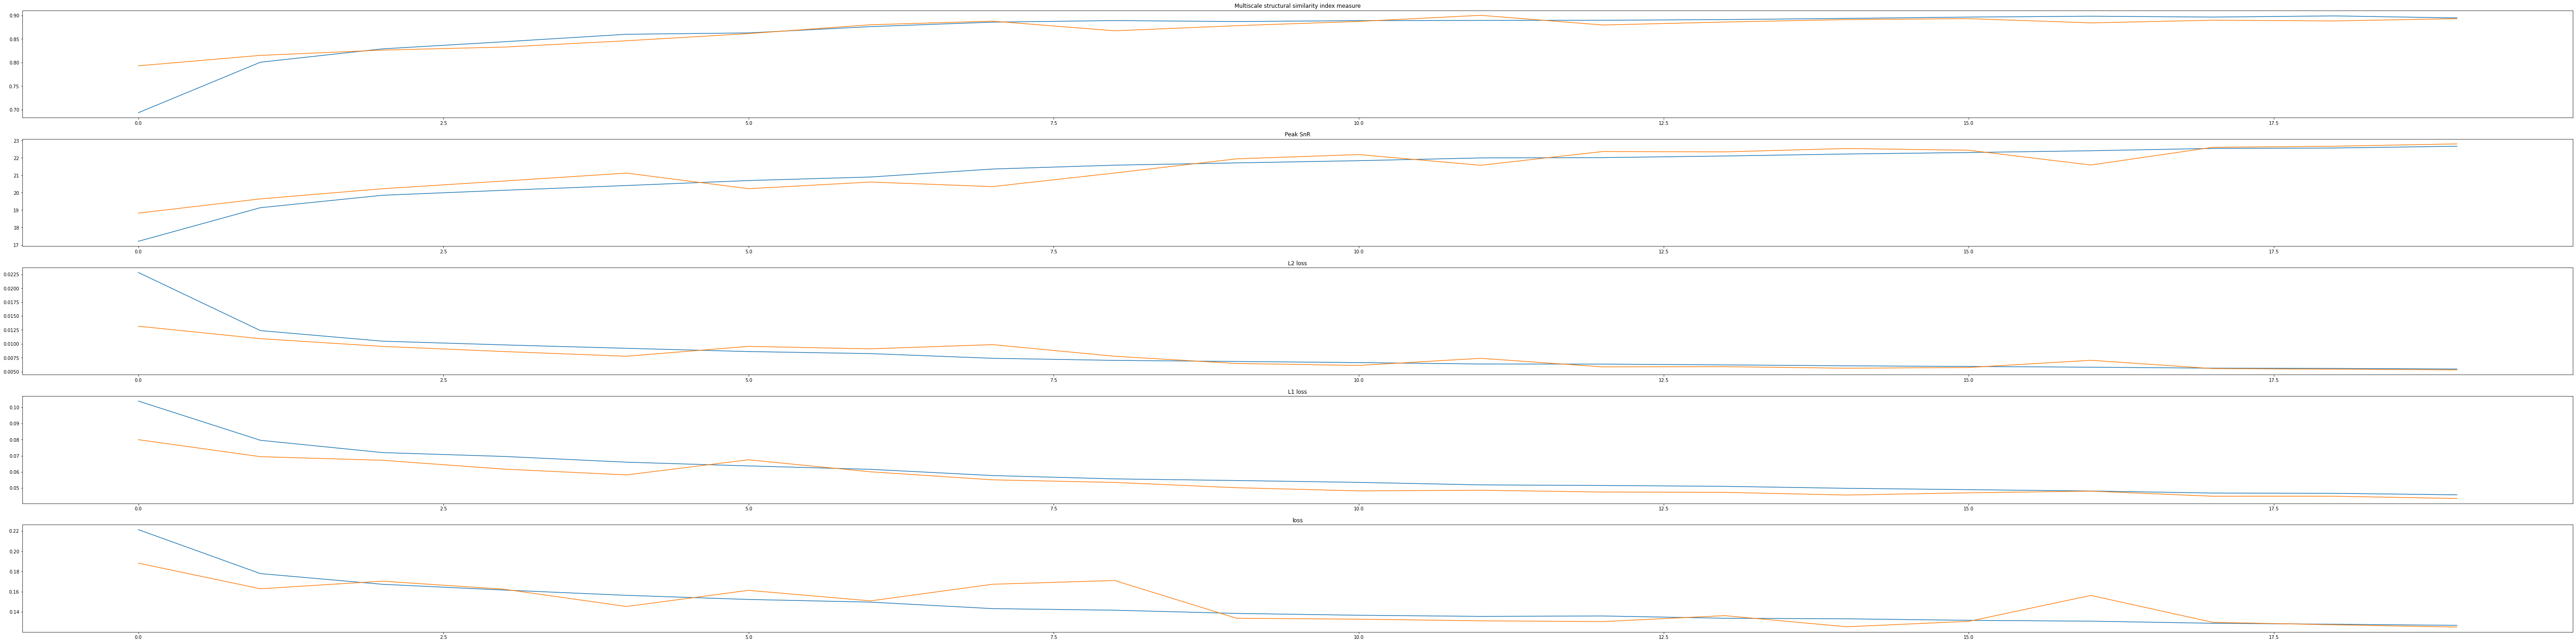

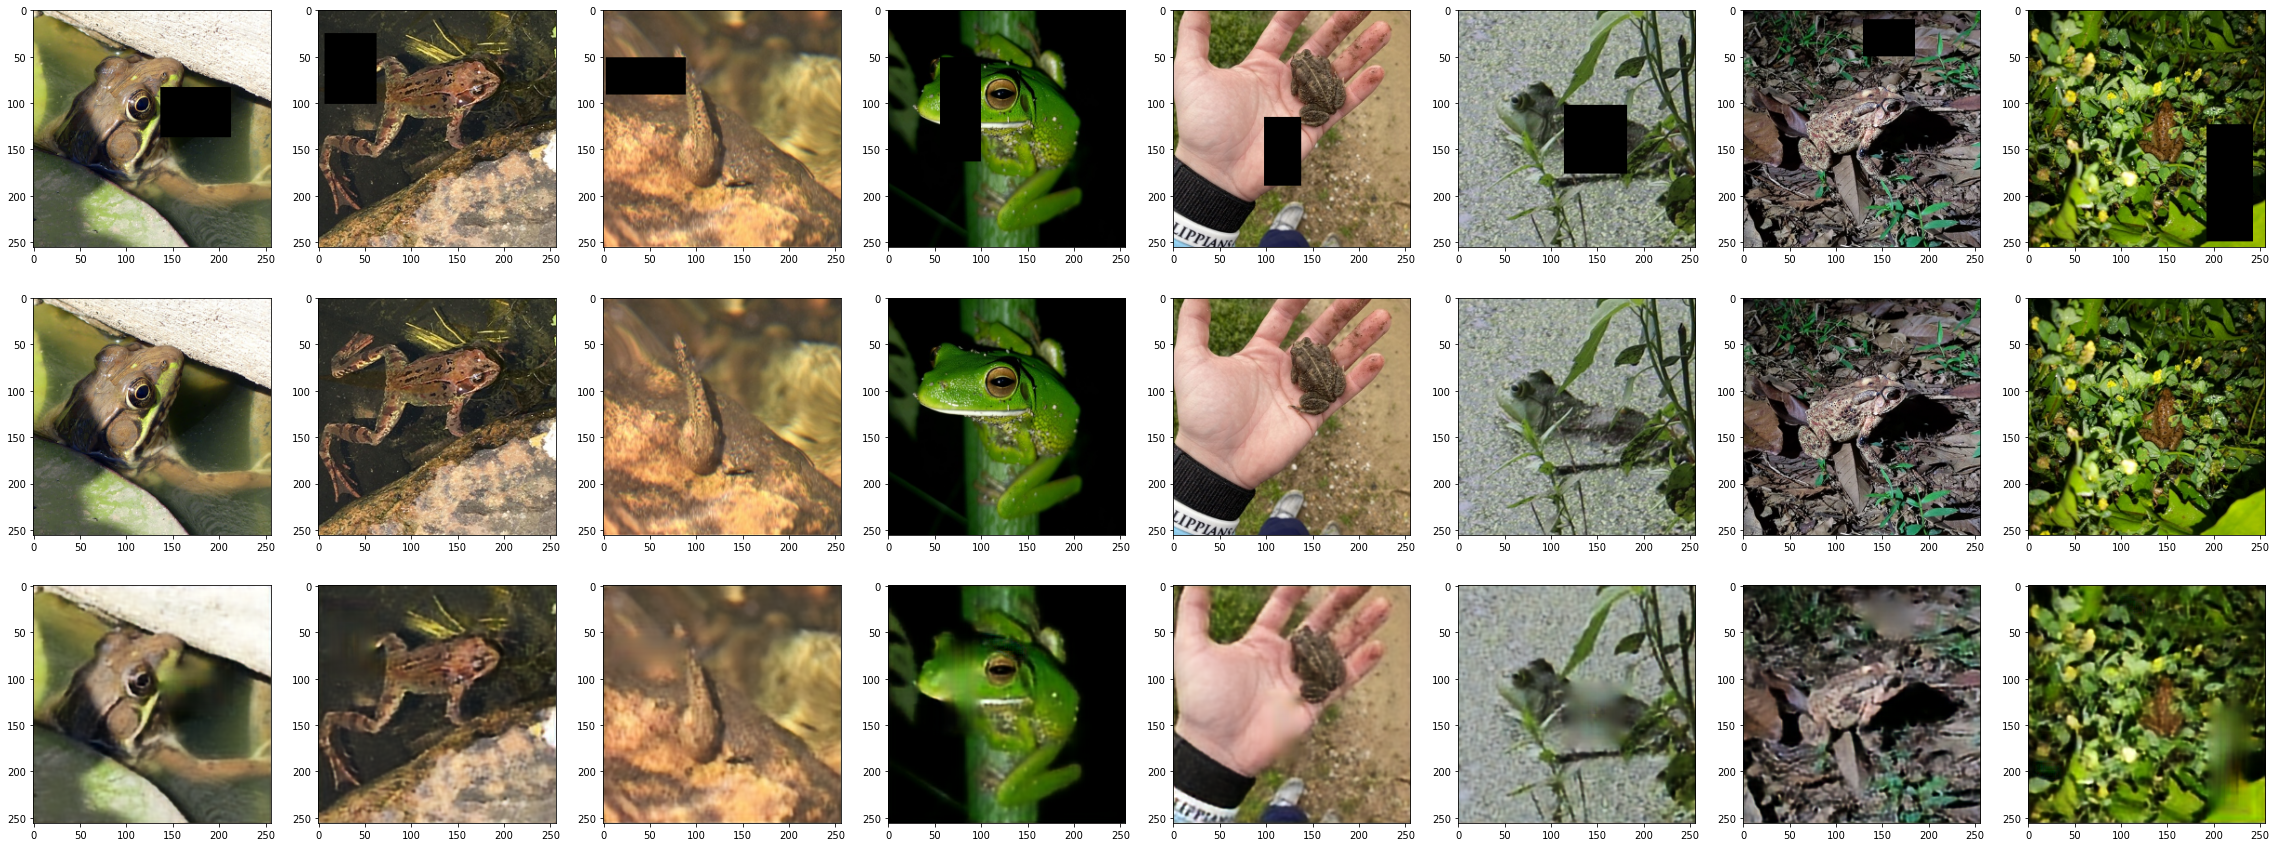

In [29]:
visualize_results(model, device, running_train_results, running_eval_results, test_dataset = validation_dataset)